In [86]:

import pandas as pd
pd.options.mode.chained_assignment = None 
import numpy as np
import re
import nltk
import os
import smart_open
import collections
import scipy.stats as stats
import tensorflow as tf
import gensim

from gensim.models.word2vec import Word2Vec
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
from gensim.test.utils import common_texts
from gensim.test.utils import get_tmpfile

from tensorflow import keras
from tensorflow.keras import Sequential, Model
from tensorflow.keras import backend as K
from tensorflow.keras.metrics import RootMeanSquaredError
from tensorflow.keras.utils import plot_model
from tensorflow.keras.optimizers import Adam, Adadelta, Nadam, Adagrad, Adamax, Ftrl, RMSprop, SGD #schedules
from tensorflow.keras.regularizers import l2
from tensorflow.keras.layers import Embedding, Dense, Flatten, LSTM, Conv1D, Conv2D, GlobalAveragePooling1D, Conv2D, ZeroPadding2D
from tensorflow.keras.layers import Bidirectional, GlobalAveragePooling2D, GlobalAveragePooling3D, BatchNormalization, Dropout
from tensorflow.keras.layers import Subtract, Add, Multiply, Activation, Input, Concatenate, Reshape, Dot, GRU 
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

from keras import optimizers

from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
%matplotlib inline

from nltk import word_tokenize
from nltk.stem import PorterStemmer
from nltk.stem.snowball import SnowballStemmer

from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, roc_auc_score
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.linear_model import SGDClassifier
from sklearn.naive_bayes import MultinomialNB
#from sklearn.model_selection import GridSearchCV, RandomSearch
from sklearn.ensemble import RandomForestClassifier

from sklearn import svm, tree
import xgboost

In [2]:
 path = '/Users/patrickrs/Documents/GitLab/revealapp/10_cleaning/src'

current_path = os.getcwd()
os.chdir(path)
%run ./Load+Clean_News.ipynb
os.chdir(current_path)

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/patrickrs/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


### Get the data

In [3]:
data = news

In [4]:
data

,SimilarityScore,sentence1,sentence2
0,4.000,last year wanted murder,last year sought murder
1,5.000,promarket economists dont object corporations ...,economists companies openly using attractivene...
2,5.000,perhaps importantly ahmadinejad destabilizing ...,perhaps important ahmadinejad destabilising in...
3,4.667,europe,europe
4,4.500,gays modern practices rejected selfindulgent,gay practical modern rejected laws
...,...,...,...
649,1.800,indian pakistani governments nearly engaged fo...,indian pakistani governments conducted nuclear...
650,3.800,iguaran stated detainees accused homicide crim...,iguaran stated detainees also involved murders...
651,2.400,3 suspected extremists released bail,1 suspected extremist provisionally released w...
652,0.800,6 czech hospital employees charged human organ...,accused charged international drug trafficking


### Import word2vec from google

In [5]:
def build_corpus(data):
    """Creates a list of lists containing words from each sentence
    
    Args:
        data: list or dataframe containing text in each cell.
    Returns: 
        A list of lists where the sublists are sentences
                and the sublist items are words."""
        
    corpus = []
    for content in data:
        corpus_temp = nltk.word_tokenize(content)
        corpus.append(corpus_temp)
    return corpus

corpus = build_corpus(pd.concat([data['sentence1'], data['sentence2']]))

In [6]:
#corpus

In [7]:
# Importing pre-trained model, updating vocab 
# and training the model (takes long to run)
def pre_trained_w2v(corpus):
    '''Function to load the GoogleNews pre-trained word2vec and
    train it further on another corpus.
    
    Args:
        corpus: A list of lists where the sublists are sentences
                and the sublist items are words.
    Returns: 
        A word2vec model with a large vocabulary.
    '''
    w2v_model_2 = Word2Vec(size=300, min_count=1)
    w2v_model_2.build_vocab(corpus)
    total_examples = w2v_model_2.corpus_count
    w2v_google_model = gensim.models.KeyedVectors.load_word2vec_format('/Users/patrickrs/Documents/Gitlab/revealapp/00_exploration/data/GoogleNews-vectors-negative300.bin', binary=True)
    w2v_model_2.build_vocab([list(w2v_google_model.vocab.keys())], update=True)
    w2v_model_2.intersect_word2vec_format('/Users/patrickrs/Documents/Gitlab/revealapp/00_exploration/data/GoogleNews-vectors-negative300.bin', binary=True, lockf=1.0)
    # intersect_word2vec_format() will let you bring vectors from an external file into a model that's already had its own vocabulary initialized
    # see https://tedboy.github.io/nlps/generated/generated/gensim.models.Word2Vec.intersect_word2vec_format.html
    w2v_model_2.train(corpus, total_examples=total_examples, epochs=w2v_model_2.iter)
    return w2v_model_2
w2v_model_2 = pre_trained_w2v(corpus)

/Users/patrickrs/.conda/envs/pre-work/lib/python3.7/site-packages/ipykernel_launcher.py:21: DeprecationWarning: Call to deprecated `iter` (Attribute will be removed in 4.0.0, use self.epochs instead).


In [8]:
embedding_matrix = np.zeros((len(w2v_model_2.wv.vocab) + 1, 300))
for i, vec in enumerate(w2v_model_2.wv.vectors):
  embedding_matrix[i] = vec
feature_size = 500
tokenizer = Tokenizer(num_words = feature_size)
# fit the tokenizer on our text
tokenizer.fit_on_texts(pd.concat([data['sentence1'], data['sentence2']]))
# get all words that the tokenizer knows
word_index = tokenizer.word_index
# put the tokens in a matrix
X1 = tokenizer.texts_to_sequences(data['sentence1'])
X1 = pad_sequences(X1)
X2 = tokenizer.texts_to_sequences(data['sentence2'])
X2 = pad_sequences(X2)

# X2 was padded with one column less:
x0 = np.zeros((X2.shape[0], X1.shape[1]))
x0[:,X1.shape[1] - X2.shape[1]:] = X2
X2 = x0

X =  np.concatenate((X1, X2), axis = 1)
# prepare the labels
y = data['SimilarityScore']

In [9]:
# split in train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False, random_state = 42)
X1_train = X_train[:, :X1.shape[1]]
X2_train = X_train[:, X1.shape[1]:X_train.shape[1]]
X1_test = X_test[:, :X1.shape[1]]
X2_test = X_test[:, X1.shape[1]:X_train.shape[1]]

In [10]:
X1.shape

(654, 20)

In [11]:
#Learning rate schedule
initial_learning_rate = 0.01
lr_schedule = keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate,
    decay_steps=100000,
    decay_rate=0.96,
    staircase=True) 

# Siamese Model

In [87]:
input_1 = Input(shape=(X1.shape[1],))
input_2 = Input(shape=(X2.shape[1],))


common_embed = Embedding(name = "Sentence_Embed",
                        input_dim = len(w2v_model_2.wv.vocab) + 1 ,
                        output_dim = 300,
                        input_length  = X1.shape[1],
                        weights = [embedding_matrix],
                        trainable=False)
lstm_1 = common_embed(input_1)
lstm_2 = common_embed(input_2)


common_lstm = GRU(128,return_sequences=True, activation="tanh", recurrent_activation='sigmoid')
vector_1 = common_lstm(lstm_1)
vector_1 = Flatten()(vector_1)

vector_2 = common_lstm(lstm_2)
vector_2 = Flatten()(vector_2)

x3 = Subtract()([vector_1, vector_2])
x3 = Multiply()([x3, x3])

x1_ = Multiply()([vector_1, vector_1])
x2_ = Multiply()([vector_2, vector_2])
x4 = Subtract()([x1_, x2_])

# https://stackoverflow.com/a/51003359/10650182
# Calculates cosine similarity
x5 = Dot(axes = 1, normalize=True)([vector_1, vector_2])
    
conc = Concatenate(axis = -1)([x5, x4, x3])

x = Dense(300, activation="tanh", name='conc_layer')(conc)
x = Dropout(0.2)(x)
out = Dense(1, activation="relu", name = 'out')(x)

model = Model([input_1, input_2], out)

In [88]:
model.compile(loss= "mse", metrics=[RootMeanSquaredError(name='rmse')],
              optimizer = SGD(learning_rate=0.01, momentum=0.0, nesterov=False))

In this network. input_1 and input_2 are pre-processed, Keras-tokenized text sequences which are to be compared for similar intent. These two text sequences are then fed through a common network of a basic embedding layer and an LSTM units. Once the feature vectors are obtained from this common network, a series of similarity measures are computed and are concatenated to be finally input into a Dense layer followed by sigmoid output unit which will finally help in classifying whether the given texts are similar or not.

In [89]:
# model.summary()

In [90]:
# plot_model(model, to_file='model.png', show_shapes=False)

In [91]:
callbacks = [
    keras.callbacks.EarlyStopping(
        restore_best_weights=True,
        # Stop training when `val_loss` is no longer improving
        monitor='val_loss',
        # "no longer improving" being defined as "no better than 1e-2 less"
        min_delta=1e-3,
        # "no longer improving" being further defined as "for at least 10 epochs"
        patience=30,
        verbose=1)
            ]

In [92]:
batch = 523
epochs = 1000
history = model.fit([X1_train, X2_train], y_train, 
                     batch, 
                     epochs = epochs, 
                     callbacks=callbacks,
                     validation_data = ([X1_test, X2_test], y_test)
                    )

Train on 523 samples, validate on 131 samples
Epoch 1/1000
523/523 [==============================] - 13s 25ms/sample - loss: 16.7160 - rmse: 4.0885 - val_loss: 7.5931 - val_rmse: 2.7556
Epoch 2/1000
523/523 [==============================] - 12s 22ms/sample - loss: 14.3402 - rmse: 3.7868 - val_loss: 5.9519 - val_rmse: 2.4396
Epoch 3/1000
523/523 [==============================] - 5s 9ms/sample - loss: 11.7670 - rmse: 3.4303 - val_loss: 4.6520 - val_rmse: 2.1569
Epoch 4/1000
523/523 [==============================] - 5s 9ms/sample - loss: 9.5886 - rmse: 3.0965 - val_loss: 3.6314 - val_rmse: 1.9056
Epoch 5/1000
523/523 [==============================] - 4s 9ms/sample - loss: 7.7608 - rmse: 2.7858 - val_loss: 2.8594 - val_rmse: 1.6910
Epoch 6/1000
523/523 [==============================] - 5s 9ms/sample - loss: 6.2280 - rmse: 2.4956 - val_loss: 2.3074 - val_rmse: 1.5190
Epoch 7/1000
523/523 [==============================] - 4s 9ms/sample - loss: 4.9244 - rmse: 2.2191 - val_loss: 1.9503 

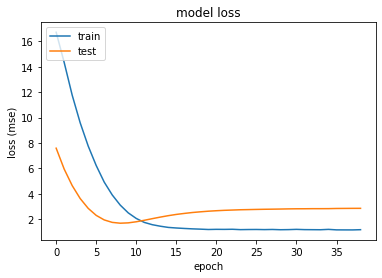

In [93]:
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss (mse)')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [94]:
# GRU better than LSTM? https://www.aclweb.org/anthology/R19-1116.pdf